## Train a character-level GPT on some smiles

The inputs here are simple smiles, which we chop up to individual characters and then train GPT on. So you could say this is a char-transformer instead of a char-rnn. Doesn't quite roll off the tongue as well. In this example we will feed it smiles from moses dataset, which we'll get it to predict character-level (i.e. token in smiles).

In [1]:
# set up logging
import logging
import pandas as pd
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [2]:
# make deterministic
from mingpt.utils import set_seed
set_seed(42)

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

In [4]:
from torch.utils.data import Dataset

class CharDataset(Dataset):

    def __init__(self, data, content):
        chars = sorted(list(set(content)))
        data_size, vocab_size = len(data), len(chars)
        print('data has %d smiles, %d unique characters.' % (data_size, vocab_size))
    
        self.stoi = { ch:i for i,ch in enumerate(chars) }
        self.itos = { i:ch for i,ch in enumerate(chars) }
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.data = data
    
    def __len__(self):
        return math.ceil(len(self.data) / (self.block_size + 1))

    def __getitem__(self, idx):
        smiles = self.data[idx]
        len_smiles = len(smiles)
        dix =  [self.stoi[s] for s in smiles]
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        return x, y


In [5]:
# you can download this moses file here https://media.githubusercontent.com/media/molecularsets/moses/master/data/dataset_v1.csv

smiles = pd.read_csv('moses.csv')['SMILES']

In [6]:
# some preprocessin, adding "<" to make every smile of max length (for us '<' is an end token)
lens = [len(i) for i in smiles]
max_len = max(lens)
smiles = [ i + str('<')*(max_len - len(i)) for i in smiles]

In [7]:
content = ' '.join(smiles)

In [8]:
block_size = max_len

In [9]:
train_dataset = CharDataset(smiles, content, )

data has 1936962 smiles, 28 unique characters.


In [10]:
from mingpt.model import GPT, GPTConfig
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  n_layer=8, n_head=8, n_embd=256)
model = GPT(mconf)

08/23/2020 20:10:48 - INFO - mingpt.model -   number of parameters: 6.347520e+06


In [11]:
from mingpt.trainer import Trainer, TrainerConfig
import math
# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=50, batch_size=128, learning_rate=6e-4,
                      lr_decay=True, warmup_tokens=32*20, final_tokens=200*len(train_dataset)*block_size,
                      num_workers=10)
trainer = Trainer(model, train_dataset, None, tconf)
trainer.train()

epoch 1 iter 260: train loss 0.59974. lr 5.999643e-04: 100%|██████████| 261/261 [00:33<00:00,  7.69it/s]
epoch 2 iter 260: train loss 0.50448. lr 5.998572e-04: 100%|██████████| 261/261 [00:36<00:00,  7.07it/s]
epoch 3 iter 260: train loss 0.47783. lr 5.996786e-04: 100%|██████████| 261/261 [00:33<00:00,  7.87it/s]
epoch 4 iter 260: train loss 0.43664. lr 5.994287e-04: 100%|██████████| 261/261 [00:35<00:00,  7.39it/s]
epoch 5 iter 260: train loss 0.39477. lr 5.991075e-04: 100%|██████████| 261/261 [00:33<00:00,  7.85it/s]
epoch 6 iter 260: train loss 0.36882. lr 5.987150e-04: 100%|██████████| 261/261 [00:34<00:00,  7.54it/s]
epoch 7 iter 260: train loss 0.35371. lr 5.982514e-04: 100%|██████████| 261/261 [00:35<00:00,  7.43it/s]
epoch 8 iter 260: train loss 0.33723. lr 5.977168e-04: 100%|██████████| 261/261 [00:34<00:00,  7.64it/s]
epoch 9 iter 260: train loss 0.33420. lr 5.971112e-04: 100%|██████████| 261/261 [00:34<00:00,  7.65it/s]
epoch 10 iter 260: train loss 0.31674. lr 5.964349e-04:

In [12]:
# alright, let's sample some molecules and draw them using rdkit

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.core.display import HTML
from rdkit.Chem.QED import qed
from rdkit.Chem import PandasTools
from mingpt.utils import sample
import seaborn as sns

08/23/2020 20:40:33 - INFO - rdkit -   Enabling RDKit 2020.03.3 jupyter extensions


In [13]:
def show(df):
    return HTML(df.to_html(notebook=True))
PandasTools.RenderImagesInAllDataFrames(images=True)

In [14]:
molecules = []
context = "C"
for i in range(100):
    x = torch.tensor([train_dataset.stoi[s] for s in context], dtype=torch.long)[None,...].to(trainer.device)
    y = sample(model, x, block_size, temperature=0.9, sample=True, top_k=5)[0]
    completion = ''.join([train_dataset.itos[int(i)] for i in y])
    completion = completion.replace('<', '')
    mol = Chem.MolFromSmiles(completion)
    if mol:
        molecules.append(mol)

RDKit ERROR: [20:40:36] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 8 18 20
RDKit ERROR: 
RDKit ERROR: [20:40:44] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 19 20 21
RDKit ERROR: 
RDKit ERROR: [20:40:46] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
RDKit ERROR: 
RDKit ERROR: [20:40:46] SMILES Parse Error: unclosed ring for input: 'CC(=O)N(Cc1cc2ccccc2n2c(=O)c3ccccc3nc12)C1C'
RDKit ERROR: [20:40:48] SMILES Parse Error: unclosed ring for input: 'CCOC(=O)N(CC)C1(C(=O)OC)OC'
RDKit ERROR: [20:40:54] SMILES Parse Error: extra close parentheses while parsing: Cn1c(SCC(=O)NC2CC2)nc2c(=O)[nH]c(=O)n2C)c1=O
RDKit ERROR: [20:40:54] SMILES Parse Error: Failed parsing SMILES 'Cn1c(SCC(=O)NC2CC2)nc2c(=O)[nH]c(=O)n2C)c1=O' for input: 'Cn1c(SCC(=O)NC2CC2)nc2c(=O)[nH]c(=O)n2C)c1=O'
RDKit ERROR: [20:40:55] Can't kekulize mol.  Unkekulized atoms: 11 12 13
RDKit ERROR: 
RDKit ERROR: [20:40:56] SMILES Parse Error: extra open parentheses for input: 'CC(C)(C)c1ccc(NC(=O)c2ccc(n2cnnn2)cc1'
R

In [15]:
"Valid molecules % = {}".format(len(molecules))

'Valid molecules % = 91'

In [16]:
mol_dict = []
for i in molecules:
    mol_dict.append({'molecule' : i, 'qed': qed(i), 'smiles': Chem.MolToSmiles(i)})

In [17]:
results = pd.DataFrame(mol_dict)

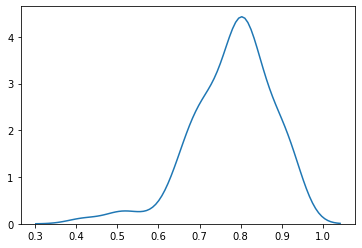

In [18]:
sns.kdeplot(results['qed'].values)

,molecule,qed,smiles
0,,0.923882,Cc1ccc(NC(=O)C(C#N)Cc2ccncc2)cc1
1,,0.866489,Cc1ccc(-c2nnn(CCC(=O)N3CCCC3C)n2)cc1
2,,0.806663,Cc1ccc(-n2cnnn2)c(C(=O)Nc2ccc(Cl)cc2)c1
3,,0.682488,Cc1nc(SCC(=O)NC2CCCC2)c2c(C)c(C)sc2n1
4,,0.891843,COc1ccc(C(=O)NC(C)C(=O)Nc2ccc(C)cc2)cc1
5,,0.923882,Cc1ccccc1NC(=O)C(C#N)Cc1ccncc1
6,,0.817494,Cc1ccc2cc(C#N)c(SCC(=O)N3CCCCC3)n2c1
7,,0.719536,Cc1ccccc1NC(=O)CSc1nnc(-c2cccs2)o1
8,,0.906757,COc1ccc(C(=O)Nc2ccc(NC(C)=O)cc2)cc1
9,,0.778309,CC(=O)Nc1ccc(C(=O)Nc2cnc3ccccc3c2)cc1

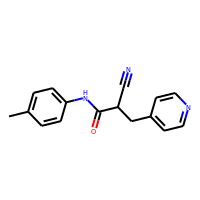
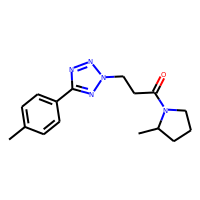
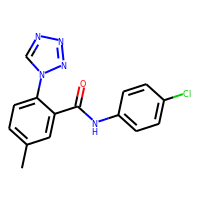
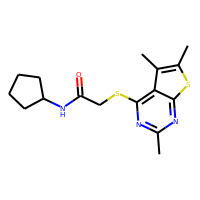
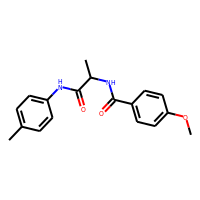
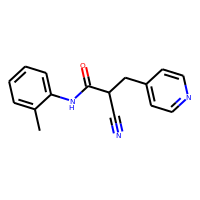
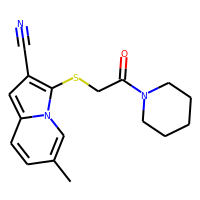
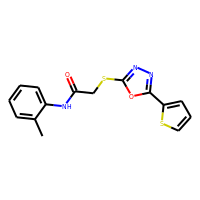
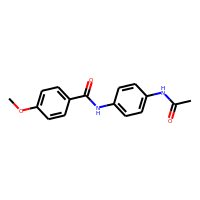
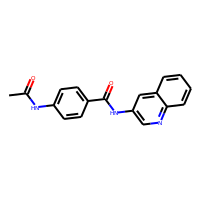
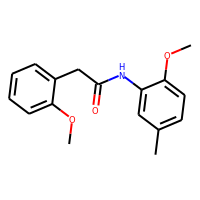
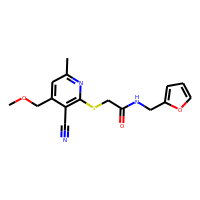
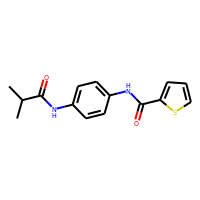
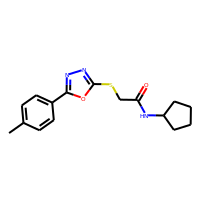
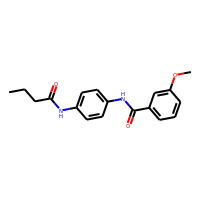
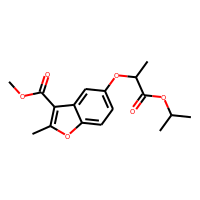
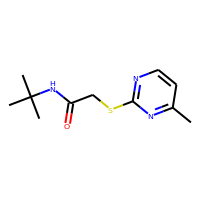
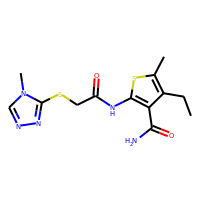
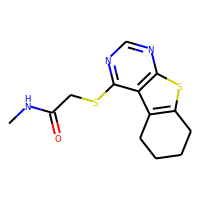
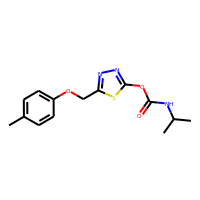
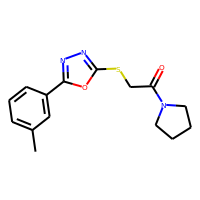
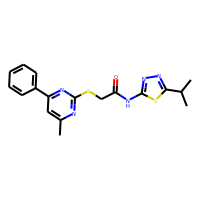
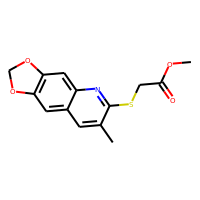
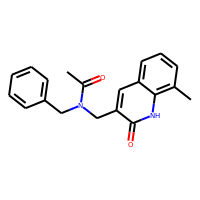
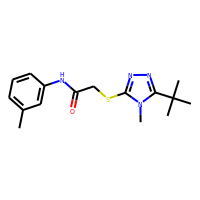
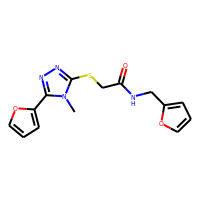
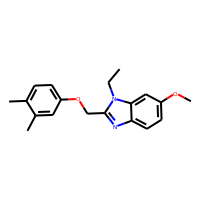
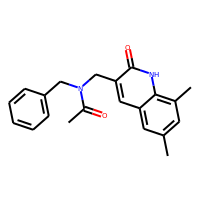
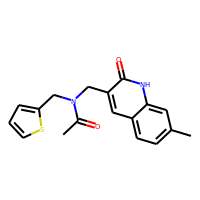
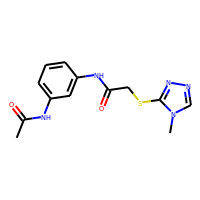
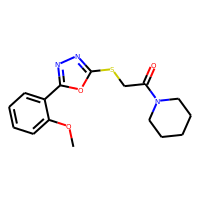
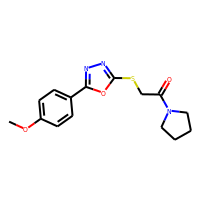
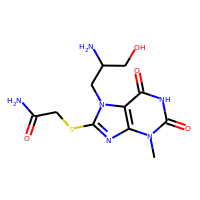
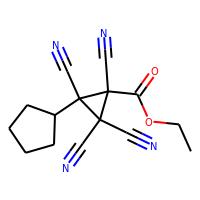
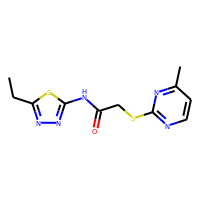
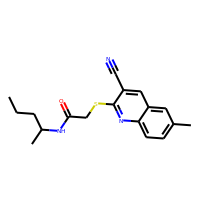
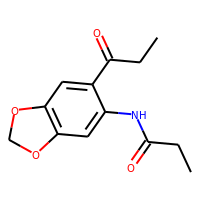
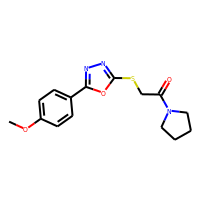
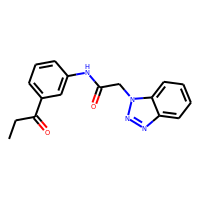
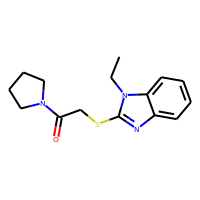
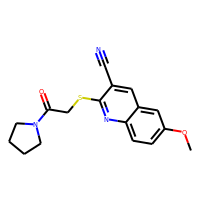
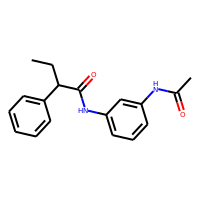
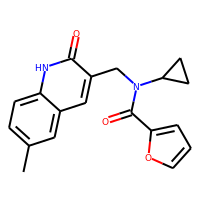
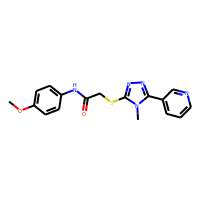
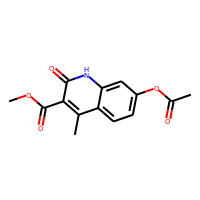
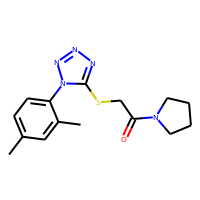
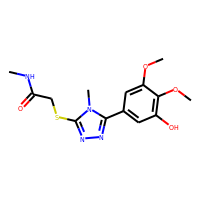
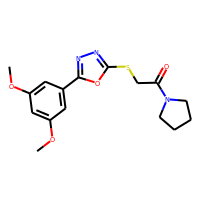
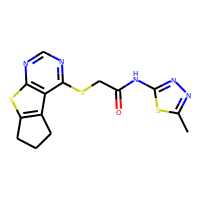
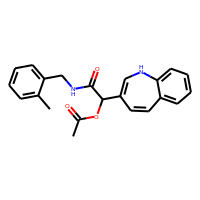
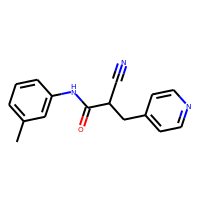
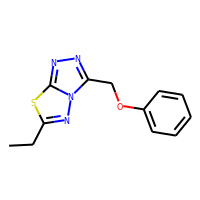
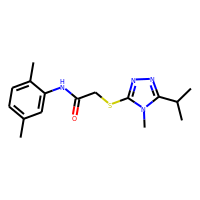
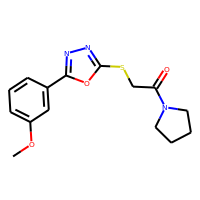
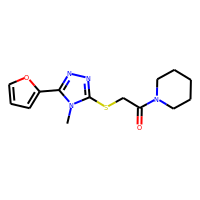
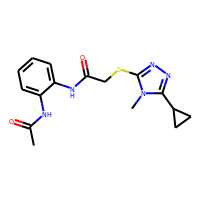
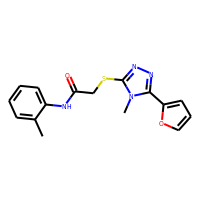
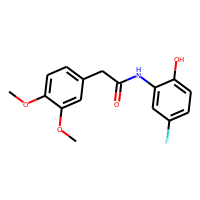
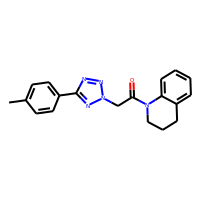
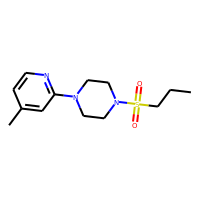
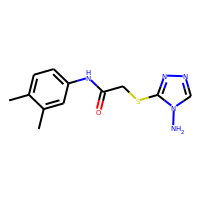
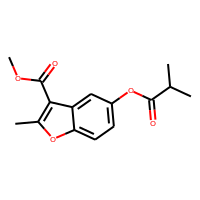
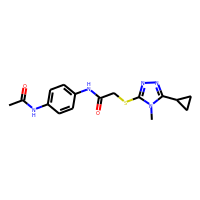
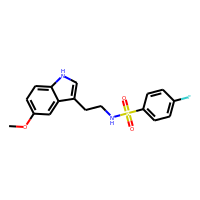
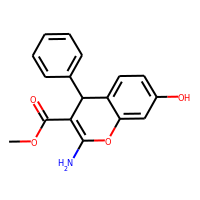
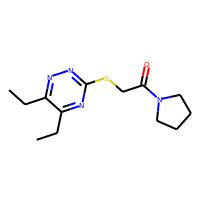
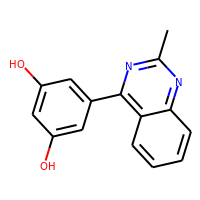
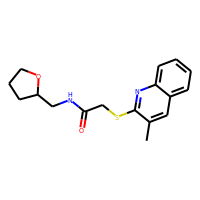
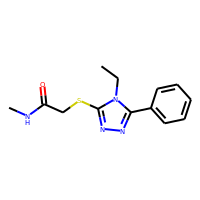
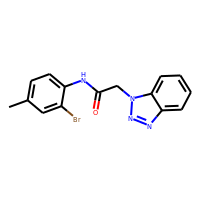
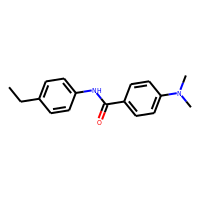
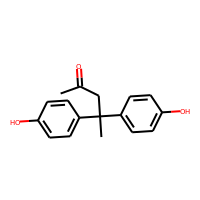
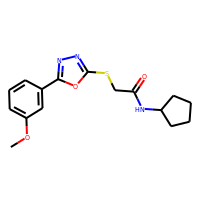
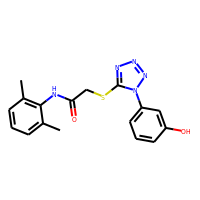
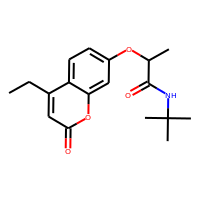
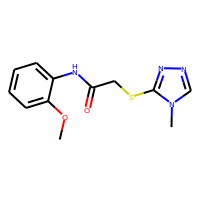
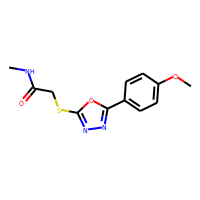
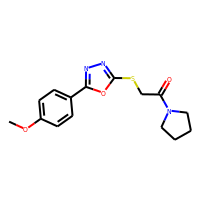
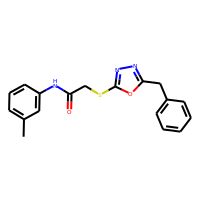
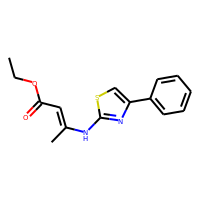
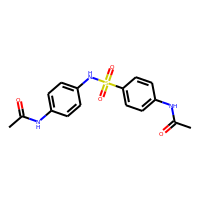
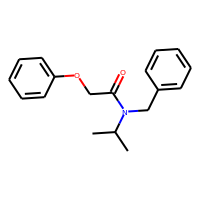
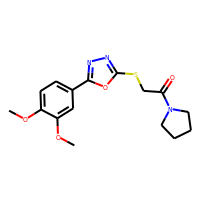
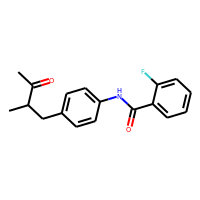
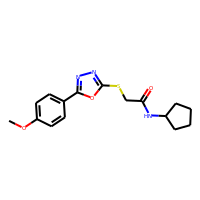
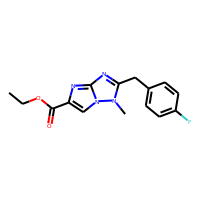
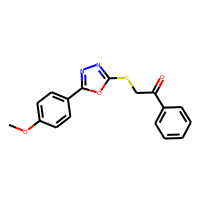
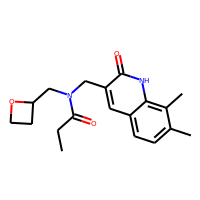
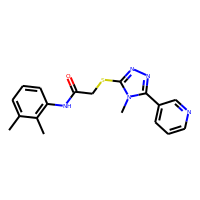
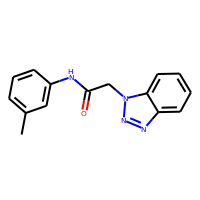
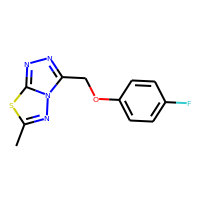

In [19]:
show(results)

In [20]:
from rdkit.DataStructs import TanimotoSimilarity
from rdkit.Chem import AllChem

In [21]:
fp_list = []
for molecule in molecules:
    fp = AllChem.GetMorganFingerprintAsBitVect(molecule, 2, nBits=1024)
    fp_list.append(fp)

diversity = []
for i in range(len(fp_list)):
    for j in range(i+1, len(fp_list)):
        current_diverity  = 1 - float(TanimotoSimilarity(fp_list[i], fp_list[j]))
        diversity.append(current_diverity)

"Diversity of molecules % = {}".format(np.mean(diversity))

'Diversity of molecules % = 0.8011225775627058'